# Исследование исторических данных о продажах игр
В рамках данного проекта предстоит проанализировать для интернет-магазина "Стримчик" исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. 

Задача: выявить определяющие успешность игры закономерности.

План работы:
- Изучить информацию о датафреймах;
- Сделать предобработку данных;
- Сделать исследовательский анализ данных;
- Составить портрет пользователя каждого региона;
- Проверить гипотезы;
- Сделать выводы.

Описание данных:

Name — название игры

Platform — платформа

Year_of_Release — год выпуска

Genre — жанр игры

NA_sales — продажи в Северной Америке (миллионы проданных копий)

EU_sales — продажи в Европе (миллионы проданных копий)

JP_sales — продажи в Японии (миллионы проданных копий)

Other_sales — продажи в других странах (миллионы проданных копий)

Critic_Score — оценка критиков (максимум 100)

User_Score — оценка пользователей (максимум 10)

Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy import stats as st

### Загрузка данных

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


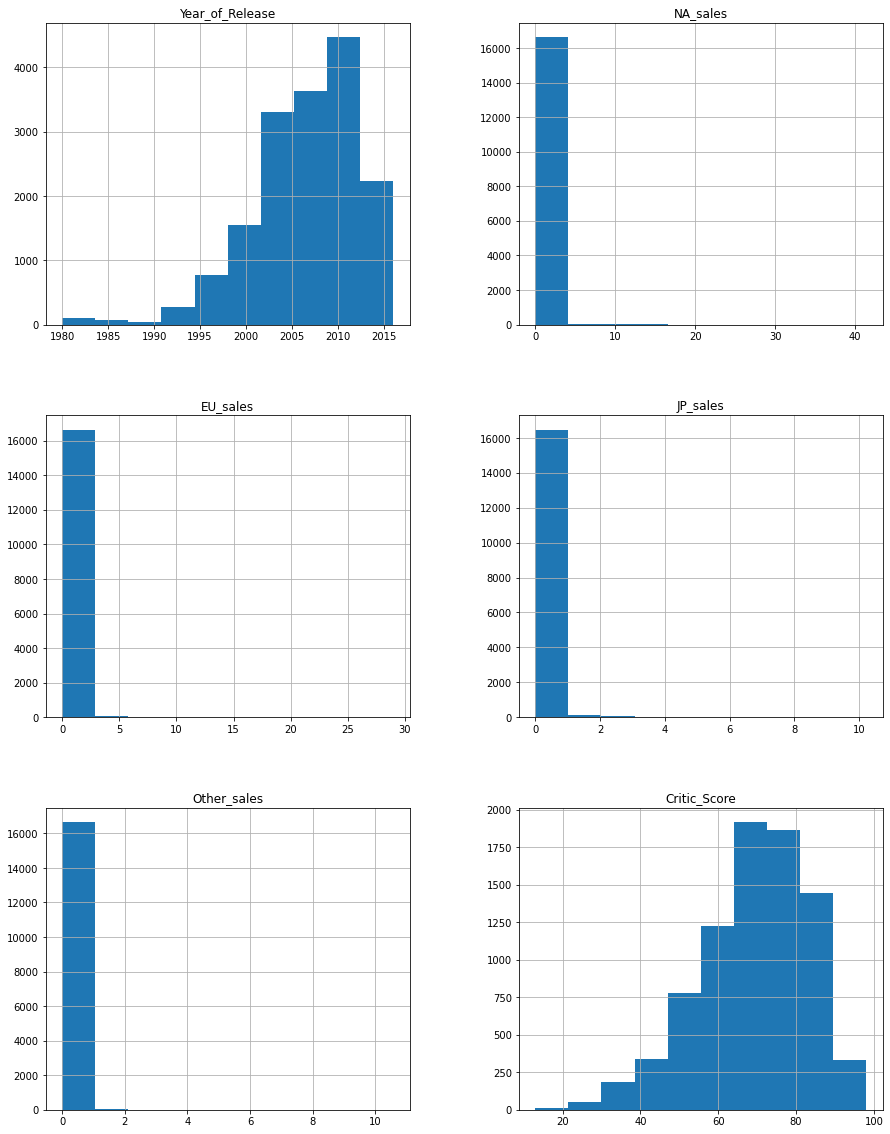

In [2]:
data = pd.read_csv('/datasets/games.csv')
display(data.head())
data.info()
data.hist(figsize=(15, 20));

Выводы:

В датафрейме 16715 записи, названия столбцов адекватны содержащимся в них данным, в столбцах Name, Platform, Genre, User_Score, Rating тип данных object, в Year_of_Release, NA_sales, EU_sales, JP_sales, Other_sales, Critic_Score тип данных float64.   

Требуется коректировка названий столбцов, изменение типа данных в Year_of_Release на int (целые числа) и User_Score на float (нужны будут для подсчета), а также предобработка данных (проверка наличия пропусков и дубликатов).

### Предобработка данных

In [3]:
# приведем в порядок названия столбцов
data.columns = data.columns.str.lower()

In [4]:
# проверяем наличие пропущенных значений в датафреймах
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [5]:
# пропуски в name и rating заполним на unknown
data['name'] = data['name'].fillna('unknown')
data['rating'] = data['rating'].fillna('unknown')

In [6]:
# удалим строки с пропусками в столбце genre
data = data.dropna(subset=['genre'])

In [7]:
# удалим строки с пропусками в столбце year_of_release
data = data.dropna(subset=['year_of_release'])

In [8]:
# пометим отрицательным значением "-1" пропуски и tbd (To Be Determined - будет определено) в столбце critic_score и user_score, 
# чтобы в дальнейшем их отфильтровать
data['critic_score'] = data['critic_score'].fillna(-1)
data['user_score'] = data['user_score'].fillna(-1)
data.loc[data['user_score'] == 'tbd', 'user_score'] = -1

In [9]:
# повторно проверим наличие пропусков
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

In [10]:
# преобразуем данные в нужные типы
data['year_of_release'] = (data['year_of_release']).astype('int')
data['user_score'] = (data['user_score']).astype('float')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [11]:
# проверяем наличие дубликатов в датафреймах
data.duplicated().sum()

0

In [12]:
# проверяем наличие неявных дубликатов
print(data[data.duplicated(['name', 'platform', 'year_of_release'])])

                name platform  year_of_release   genre  na_sales  eu_sales  \
16230  Madden NFL 13      PS3             2012  Sports       0.0      0.01   

       jp_sales  other_sales  critic_score  user_score rating  
16230       0.0          0.0          83.0         5.5      E  


In [13]:
data = data.drop_duplicates(['name', 'platform', 'year_of_release'])
print(data[data.duplicated(['name', 'platform', 'year_of_release'])].count())

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64


In [14]:
# посчитаем суммарные продажи во всех регионах 
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unknown,31.38


Выводы:

- Были изменены названия столбцов; 
- Были выявлены пропущенные значения (причиной которых мог быть человеческий фактор или отсутствие данных об оценке в источнике для некоторых данных);
- В столбцах  name и rating пропуски обозначены как unknown, так как данные других столбцов этих строк могут пригодиться для анализа. В столбце year_of_release и genre принято решение удалить строки с пропусками (таких строк немного, а данные по этому параметру важны для дальнейшего анализа). В столбце critic_score, user_score пропуски и tbd обозначены как -1 для дальнейшей фильтрации;
- Дубликаты не обнаружены; были удалены неявные дубликаты;
- Столбец year_of_release приведен к int типу, user_score к float в соответствии с данными содержащимися в них;
- Были подсчитаны суммарные продажи во всех регионах (в total_sales).

Данные готовы к исследовательскому анализу.


### Исследовательский анализ данных

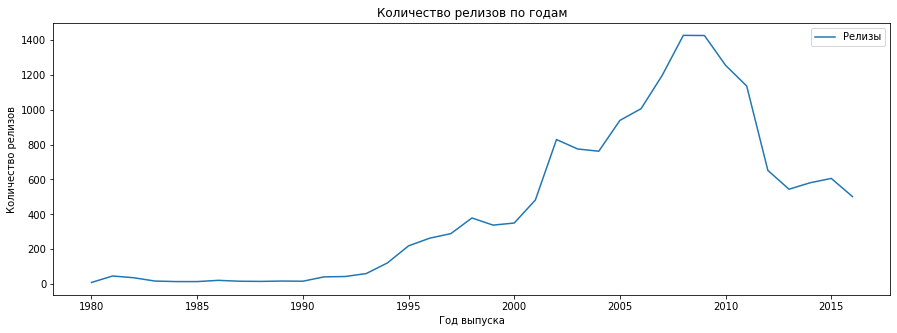

In [15]:
# Посмотрим, сколько игр выпускалось в разные годы

plt.figure(figsize=(15,5))
plt.title('Количество релизов по годам')
plt.plot(data.groupby('year_of_release')['name'].count(), label='Релизы')
plt.legend()
plt.xlabel('Год выпуска')
plt.ylabel('Количество релизов')
plt.show()

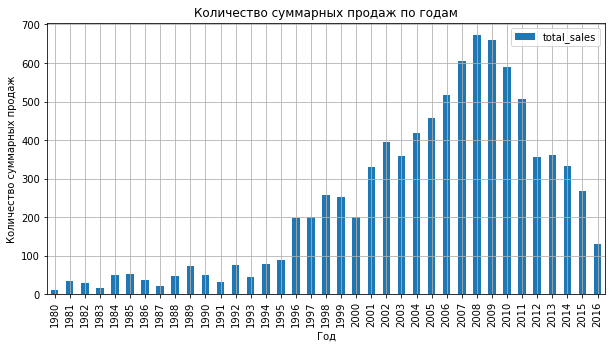

count    16443.000000
mean      2006.485921
std          5.875546
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

In [16]:
# Посмотрим, как изменялись суммарные продажи в разные годы
(
    data.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
    .plot(kind='bar' , grid=True, figsize=(10, 5))
)
plt.title('Количество суммарных продаж по годам')
plt.xlabel('Год')
plt.ylabel('Количество суммарных продаж')
plt.show()

data['year_of_release'].describe()

В датафрейме представлены игры с 1980 по 2016 год. С 90-х по 2009 год наблюдался рост количества релизов игр, с 2009 года прослеживается спад. С 2012 года объем выпуска игр стабилизировался и год от года данные отличаются несильно (500-600). Для исследования лучше выбрать последние 5 лет, так как этот период должен отражать новейшие тренды в индустрии.

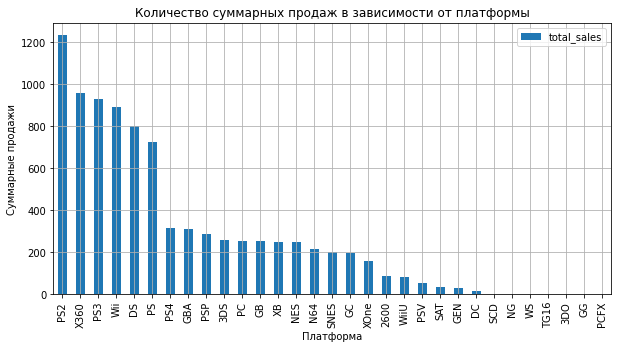

In [17]:
# Посмотрим, как менялись продажи по платформам. 
(
    data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .plot(kind='bar' , grid=True, figsize=(10, 5))
)
plt.title('Количество суммарных продаж в зависимости от платформы')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи')
plt.show()

In [18]:
# 6 компаний явно отличаются от остальных. Рассмотрим их отдельно

top_sales = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index().head(6)['platform'].tolist()
top_sales

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

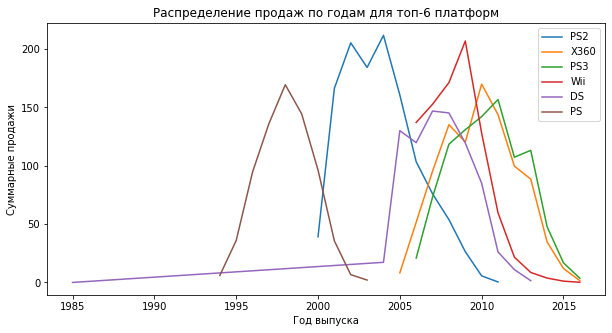

In [19]:
# Выберем платформы с наибольшими суммарными продажами и построим распределение по годам

for name in top_sales:
    (
    data.query('platform == @name')
    .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
    .sort_values('year_of_release', ascending = False)['total_sales']
    .plot(figsize = (10, 5), label=name)
    )
    plt.title('Распределение продаж по годам для топ-6 платформ')
    plt.xlabel('Год выпуска')
    plt.ylabel('Суммарные продажи')
    plt.legend() 

In [20]:
display(data.query('platform == "DS" and year_of_release < 2003'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,-1.0,-1.0,unknown,0.02


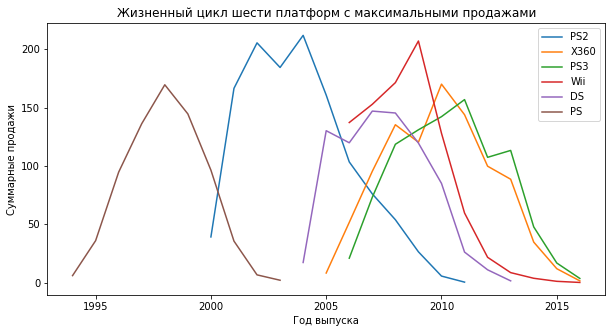

In [21]:
data = data.drop(index = 15957)
for name in top_sales:
    (
    data.query('platform == @name')
    .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
    .sort_values('year_of_release', ascending = False)['total_sales']
    .plot(figsize = (10, 5), label=name)
    )
    plt.title('Жизненный цикл шести платформ с максимальными продажами')
    plt.xlabel('Год выпуска')
    plt.ylabel('Суммарные продажи')
    plt.legend() 

Из графиков видно, что от срока появления платформы до их исчезновения как правило проходит около 10 лет, соответственно нам интересны платформы, созданные в диапазоне 5 лет, у которых должен наблюдаться рост в продажах.

In [22]:
# Возьмем данные за соответствующий актуальный для прогноза период - 5 лет 
#(то есть для прогноза на 2017 будем рассматривать с 2012) 
actual_platforms = (data
    .query('year_of_release >= 2012')
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .reset_index().head(10)['platform'].tolist()
    )                         
actual_platforms

['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii', 'DS']

In [23]:
actual_data = data.query('year_of_release >= 2012').copy().reset_index(drop= True)
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,unknown,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,unknown,14.60
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


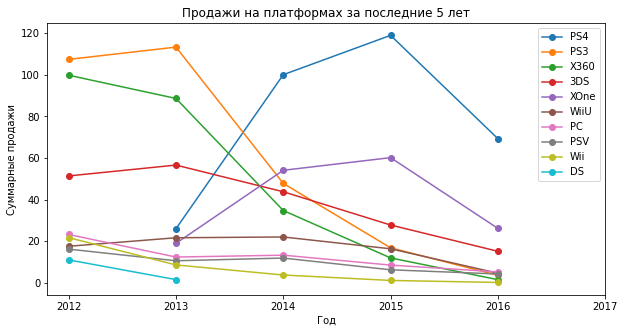

In [24]:
#Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.

for name in actual_platforms:
    (
    actual_data.query('platform == @name')
    .pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
    .sort_values('year_of_release', ascending = False)['total_sales']
    .plot(kind='line', style='o-',  figsize = (10, 5), label=name)
    )
    plt.title('Продажи на платформах за последние 5 лет')
    plt.xticks(np.arange(2012, 2018, step=1))
    plt.xlabel('Год')
    plt.ylabel('Суммарные продажи')
    plt.legend() 

За определенный нами актуальный период в 5 лет продажи падают на всех платформах. Относительно высокие продажи на 2016 году у  PS4 и XOne.

In [25]:
# Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам
actual_data['total_sales'].describe()

count    2885.000000
mean        0.501393
std         1.249340
min         0.010000
25%         0.040000
50%         0.120000
75%         0.430000
max        21.050000
Name: total_sales, dtype: float64

Text(0, 0.5, 'Продажи по платформам')

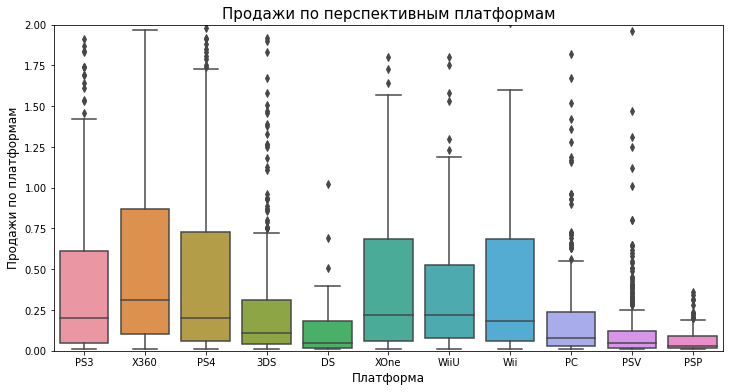

In [26]:
plt.figure(figsize=(12,6))
ax = seaborn.boxplot(data=actual_data, x='platform', y='total_sales')
ax.set(ylim=(0,2))
plt.title('Продажи по перспективным платформам', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Продажи по платформам',fontsize=12)

Медианное значение - 0,12, но на графиках наблюдается большой разброс и в медианном значении и в значениях первого и третьего квартилей. У всех консолей отмечаются выбросы на графиках.

In [27]:
# код ревьюера

print(actual_data[(actual_data['platform'] == 'PS4') & (actual_data['user_score'] > -1) & (actual_data['critic_score'] > -1)].shape[0])
print(actual_data[(actual_data['platform'] == 'PS4') & (actual_data['user_score'] > -1)].shape[0])
print(actual_data[(actual_data['platform'] == 'PS4') & (actual_data['critic_score'] > -1)].shape[0])


249
257
252


In [28]:
# Соотнесем отзывы пользователей и критиков с продажами игр на 5 популярных платформах
platforms_5 = (actual_data
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .reset_index().head(5)['platform'].tolist()
    )                         
platforms_5

['PS4', 'PS3', 'X360', '3DS', 'XOne']

Корреляция между оценками пользователей и продажами по платформе PS4  = -0.031957110204556376


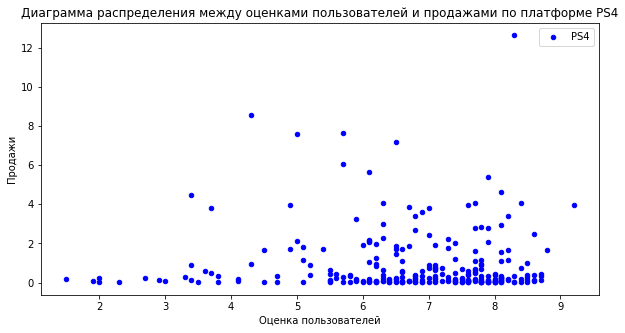

Корреляция между оценками пользователей и продажами по платформе PS3  = -0.006205767686051523


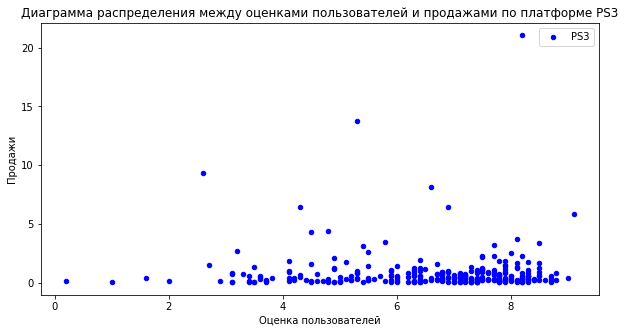

Корреляция между оценками пользователей и продажами по платформе X360  = 0.006163978646213326


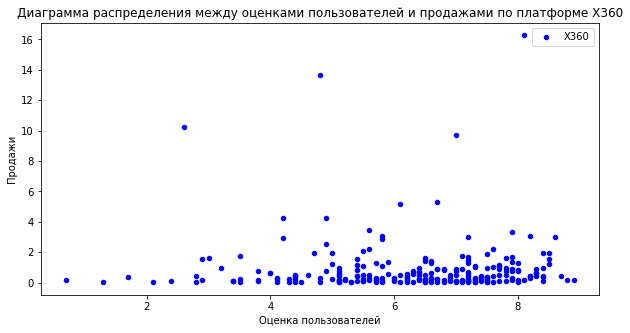

Корреляция между оценками пользователей и продажами по платформе 3DS  = 0.19758263411038599


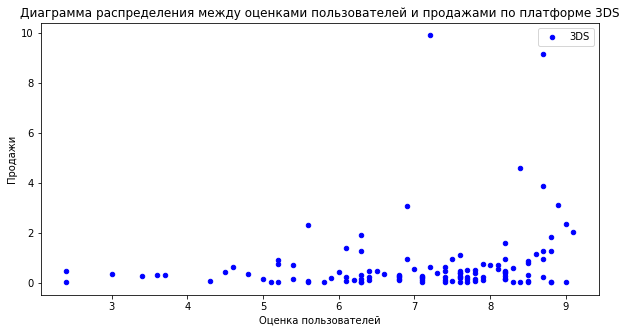

Корреляция между оценками пользователей и продажами по платформе XOne  = -0.06892505328279414


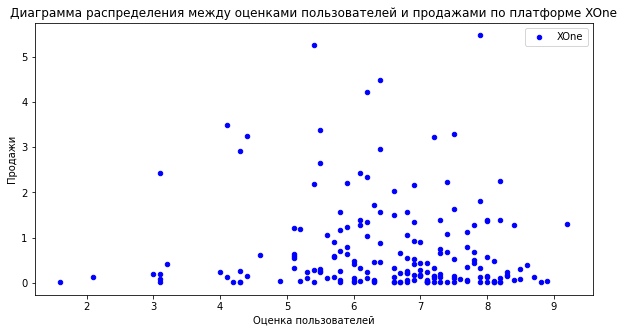

In [29]:
for name in platforms_5:
    (
    actual_data
        .query('platform == @name and user_score > -1')
        .plot(x='user_score', 
          y='total_sales', 
          kind='scatter', 
          figsize=(10, 5), 
          color='blue')
    )
    plt.title(f'Диаграмма распределения между оценками пользователей и продажами по платформе {name}')
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи')
    plt.legend([name])
    print(f'Корреляция между оценками пользователей и продажами по платформе {name}  =', actual_data.query('platform == @name and user_score > -1')['user_score'].corr(actual_data.query('platform == @name and user_score > -1')['total_sales']))
    plt.show()

Корреляция между оценками критиков и продажами по платформе PS4  = 0.40656790206178095


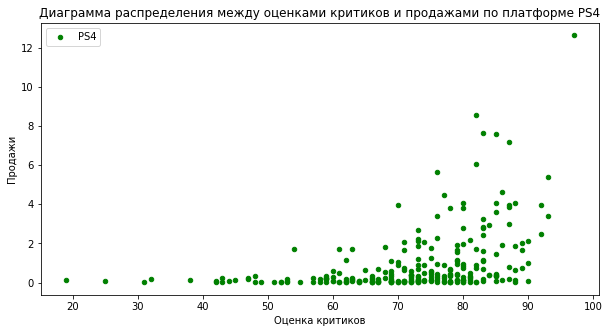

Корреляция между оценками критиков и продажами по платформе PS3  = 0.3341517575509856


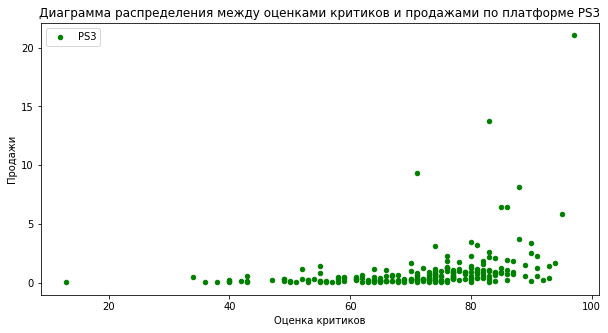

Корреляция между оценками критиков и продажами по платформе X360  = 0.3605734888507336


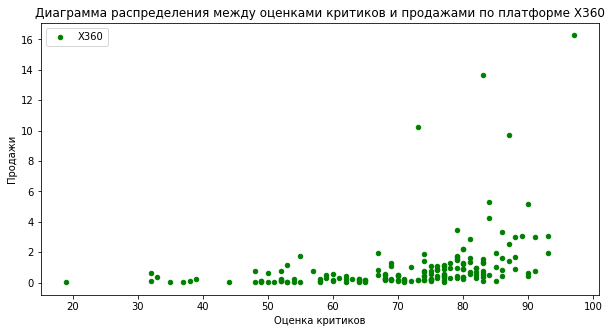

Корреляция между оценками критиков и продажами по платформе 3DS  = 0.3208028695360785


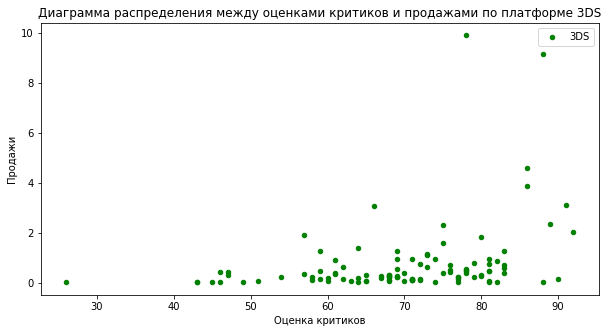

Корреляция между оценками критиков и продажами по платформе XOne  = 0.4169983280084017


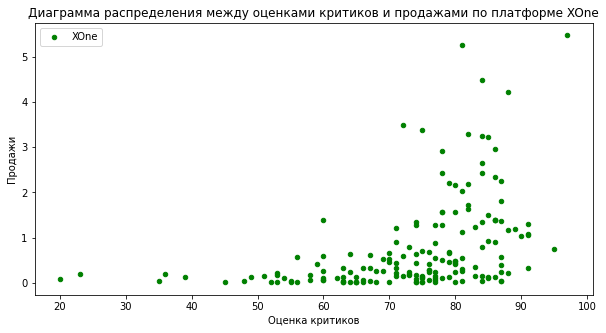

In [30]:
for name in platforms_5:
    (
    actual_data
        .query('platform == @name and critic_score > -1')
        .plot(x='critic_score', 
          y='total_sales', 
          kind='scatter', 
          figsize=(10, 5), 
          color='green')
    )
    plt.title(f'Диаграмма распределения между оценками критиков и продажами по платформе {name}')
    plt.xlabel('Оценка критиков')
    plt.ylabel('Продажи')
    plt.legend([name])
    print(f'Корреляция между оценками критиков и продажами по платформе {name}  =', actual_data.query('platform == @name and critic_score > -1')['critic_score'].corr(actual_data.query('platform == @name and critic_score > -1')['total_sales']))
    plt.show()

Общая корреляция между оценками пользователей и продажами находится в диапазоне от -0.006 до 0.19 (слабая связь). Общая корреляция между оценками критиков и продажами находится в диапазоне от 0.32 до 0.41 (умеренная связь).

In [31]:
# Соотнесем выводы с продажами игр на других платформах
print('Общая корреляция между оценками пользователей и продажами = ', actual_data.query('user_score > -1')['user_score'].corr(actual_data['total_sales']))
print('Общая корреляция между оценками критиков и продажами = ', actual_data.query('critic_score > -1')['critic_score'].corr(actual_data['total_sales']))

Общая корреляция между оценками пользователей и продажами =  0.0041944811069172284
Общая корреляция между оценками критиков и продажами =  0.30863336128976016


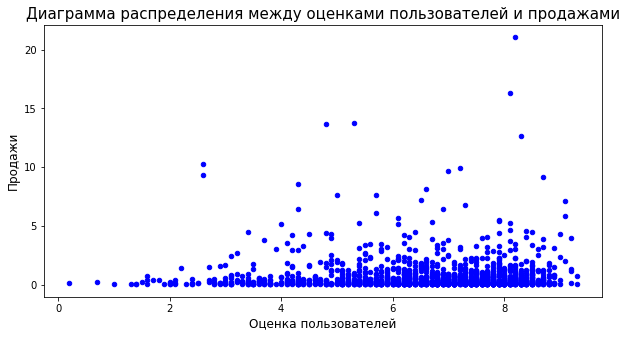

In [32]:
(
 actual_data.query('user_score > -1')
    .plot(x='user_score', 
          y='total_sales', 
          kind='scatter', 
          figsize=(10, 5), 
          color='blue')
)

plt.title('Диаграмма распределения между оценками пользователей и продажами', fontsize=15)
plt.xlabel('Оценка пользователей', fontsize=12)
plt.ylabel('Продажи',fontsize=12)
plt.show()

Расчитанная корреляция указывает что между оценкой пользователей и продажами по всей совокупности данных слабая связь (приближается к 0,004).

<function matplotlib.pyplot.show(close=None, block=None)>

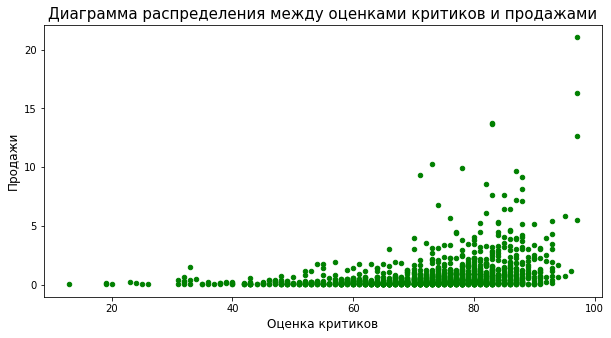

In [33]:
(
 actual_data.query('critic_score > -1')
    .plot(x='critic_score', 
          y='total_sales', 
          kind='scatter', 
          figsize=(10, 5), 
          color='green')
)
plt.title('Диаграмма распределения между оценками критиков и продажами', fontsize=15)
plt.xlabel('Оценка критиков', fontsize=12)
plt.ylabel('Продажи',fontsize=12)
plt.show

Общая корреляция между оценками критиков и продажами:  0.3 (умеренная связь).

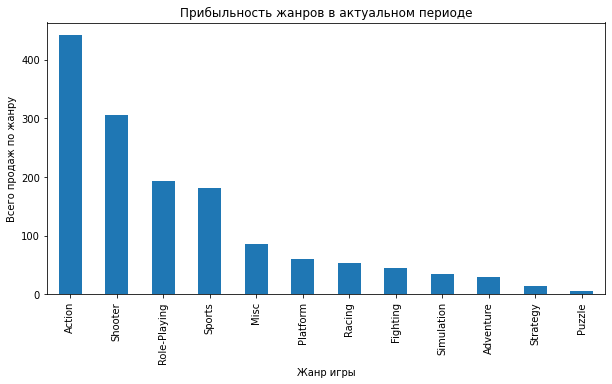

In [34]:
# Посмотрим на общее распределение игр по жанрам. 
(actual_data
 .pivot_table(index='genre', values='total_sales', aggfunc='sum')
 .sort_values('total_sales', ascending=False)
 .plot(kind='bar', y='total_sales', figsize=(10, 5), legend=False,title = 'Прибыльность жанров в актуальном периоде')
 .set(xlabel='Жанр игры', ylabel='Всего продаж по жанру'))

plt.show()

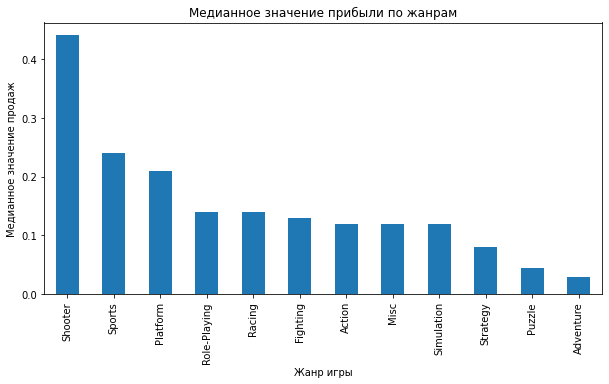

In [35]:
(
 actual_data
 .pivot_table(index='genre', values='total_sales', aggfunc='median')
 .sort_values('total_sales', ascending=False).plot(kind='bar', y='total_sales', figsize=(10, 5), legend=False,title = 'Медианное значение прибыли по жанрам')
 .set(xlabel='Жанр игры', ylabel='Медианное значение продаж'))

plt.show()

За последние годы наиболее востребованными являются Action, Shooter, Role-Playing. У жанров Shooter, Sports и Platform большее медианное значение прибыли.

Выводы:

- В датафрейме представлены игры с 1980 по 2016 год. С 90-х по 2009 год наблюдался рост количества релизов игр, с 2009 года прослеживается спад. С 2012 года объем выпуска игр стабилизировался и год от года данные отличаются несильно (500-600). Для исследования лучше выбрать последние 5 лет, так как этот период должен отражать новейшие тренды в индустрии.

- Из графиков видно, что от срока появления платформы до их исчезновения как правило проходит около 10 лет, следовательно для нас интересны платформы, созданные в диапазоне 5 лет, у которых должен наблюдаться рост в продажах.

- За определенный нами актуальный период в 5 лет продажи падают на всех платформах. Относительно высокие продажи на 2016 году у  PS4 и XOne.

- Анализ продаж на перспективных платформах показал большой разброс и в медианном значении, и в значениях первого и третьего квартилей. У всех консолей отмечаются выбросы на графиках.

- Диаграммы распределения явно показывают отсутствие линейной связи между оценкой пользователей и продажами и умеренную связь с оценками критиков и продажами для популярных платформ (что подтверждается коэффициентами корреляции).

- Расчитанная корреляция указывает что между оценкой пользователей и продажами по всей совокупности данных слабая связь (приближается к 0,004). Общая корреляция между оценками критиков и продажами:  0.3 (умеренная связь).

- За последние годы наиболее востребованными жанрами игр являются Action, Shooter, Role-Playing. У жанров Shooter, Sports и Platform большее медианное значение прибыли.



### Составьте портрет пользователя каждого региона

In [36]:
na = (
      actual_data
        .pivot_table(index=['platform'], values=['na_sales'], aggfunc='sum')
        .sort_values('na_sales', ascending=False).reset_index()
     )
na.loc[5:,'platform'] = 'Other'
na.loc[5,'na_sales'] =  na.loc[5:,'na_sales'].sum().round(2)
na = na.iloc[0:6, :]

eu = (
      actual_data
        .pivot_table(index=['platform'], values=['eu_sales'], aggfunc='sum')
        .sort_values('eu_sales', ascending=False).reset_index()
     )
eu.loc[5:,'platform'] = 'Other'
eu.loc[5,'eu_sales'] =  eu.loc[5:,'eu_sales'].sum().round(2)
eu = eu.iloc[0:6, :]

jp = (
      actual_data
        .pivot_table(index=['platform'], values=['jp_sales'], aggfunc='sum')
        .sort_values('jp_sales', ascending=False).reset_index()
     )
jp.loc[5:,'platform'] = 'Other'
jp.loc[5,'jp_sales'] =  jp.loc[5:,'jp_sales'].sum().round(2)
jp = jp.iloc[0:6, :]
ps = pd.merge(na, eu, left_index=True, right_index=True)
ps = pd.merge(ps, jp, left_index=True, right_index=True)
ps.rename(columns = {'platform_x':'na_platform', 'platform_y':'eu_platform', 'platform':'jp_platform'}, inplace = True )

ps

,na_platform,na_sales,eu_platform,eu_sales,jp_platform,jp_sales
0,X360,140.05,PS4,141.09,3DS,87.79
1,PS4,108.74,PS3,106.85,PS3,35.29
2,PS3,103.38,X360,74.52,PSV,21.04
3,XOne,93.12,XOne,51.59,PS4,15.96
4,3DS,55.31,3DS,42.64,WiiU,13.01
5,Other,90.37,Other,90.12,Other,19.49


In [37]:
data = {'region': ['NA - Америка', 'EU - Европа', 'JP - Япония'], 'platform': ['na_platform', 'eu_platform', 'jp_platform'], 'sales': ['na_sales', 'eu_sales', 'jp_sales']} 
regions = pd.DataFrame(data) 
regions

,region,platform,sales
0,NA - Америка,na_platform,na_sales
1,EU - Европа,eu_platform,eu_sales
2,JP - Япония,jp_platform,jp_sales


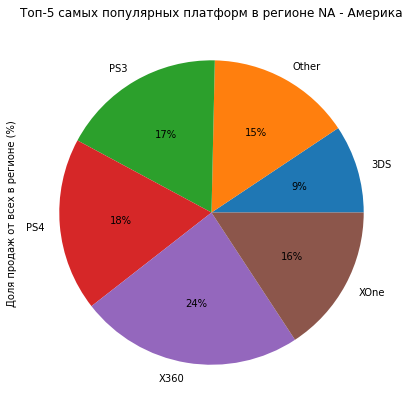

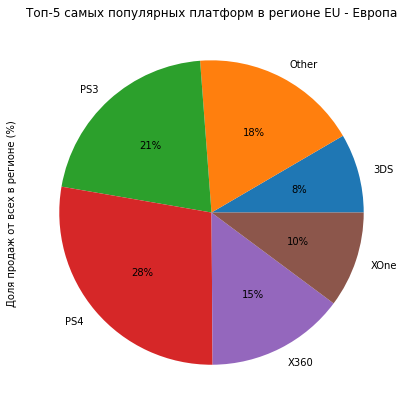

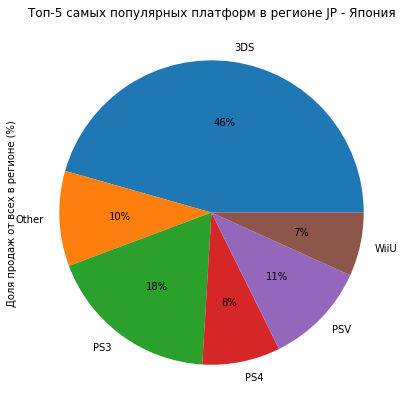

In [38]:
for i in regions.index :
    name = regions['region'][i]
    (ps.pivot_table(index=regions['platform'][i], values=regions['sales'][i], aggfunc='sum')
     .plot(kind='pie', y=regions['sales'][i], autopct='%1.0f%%', figsize=(7, 7), legend=False)
     .set(ylabel='Доля продаж от всех в регионе (%)')
    )
    
    plt.title(f'Топ-5 самых популярных платформ в регионе {name}')
    plt.show()

In [39]:
print('ТОП - 5 платформ по регионам NA, EU, JP и доли продаж по ним')
ps.na_sales = round(ps.na_sales/ps.na_sales.sum()*100, 2)
ps.eu_sales = round(ps.eu_sales/ps.eu_sales.sum()*100, 2)
ps.jp_sales = round(ps.jp_sales/ps.jp_sales.sum()*100, 2)
ps

ТОП - 5 платформ по регионам NA, EU, JP и доли продаж по ним


,na_platform,na_sales,eu_platform,eu_sales,jp_platform,jp_sales
0,X360,23.70,PS4,27.84,3DS,45.59
1,PS4,18.40,PS3,21.08,PS3,18.32
2,PS3,17.49,X360,14.70,PSV,10.93
3,XOne,15.76,XOne,10.18,PS4,8.29
4,3DS,9.36,3DS,8.41,WiiU,6.76
5,Other,15.29,Other,17.78,Other,10.12


В топ в регионах NA и EU входят одинаковые платформы: PS4, PS3, X360. На рынке JP присутствуют специализированные региональные платформы (3DS занимает 46% рынка).

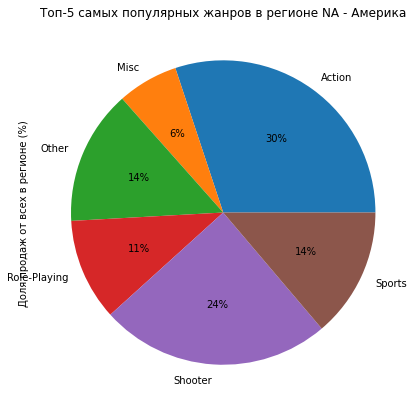

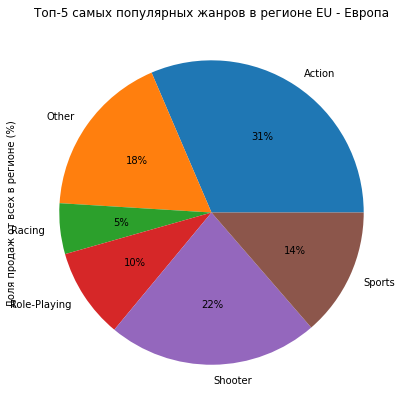

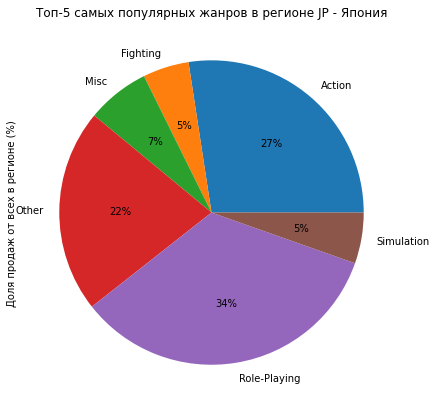

In [40]:
na = (
      actual_data
        .pivot_table(index=['genre'], values=['na_sales'], aggfunc='sum')
        .sort_values('na_sales', ascending=False).reset_index()
     )
na.loc[5:,'genre'] = 'Other'
na.loc[5,'na_sales'] =  na.loc[5:,'na_sales'].sum().round(2)
na = na.iloc[0:6, :]
eu = (
      actual_data
        .pivot_table(index=['genre'], values=['eu_sales'], aggfunc='sum')
        .sort_values('eu_sales', ascending=False).reset_index()
     )
eu.loc[5:,'genre'] = 'Other'
eu.loc[5,'eu_sales'] =  eu.loc[5:,'eu_sales'].sum().round(2)
eu = eu.iloc[0:6, :]
jp = (
      actual_data
        .pivot_table(index=['genre'], values=['jp_sales'], aggfunc='sum')
        .sort_values('jp_sales', ascending=False).reset_index()
     )
jp.loc[5:,'genre'] = 'Other'
jp.loc[5,'jp_sales'] =  jp.loc[5:,'jp_sales'].sum().round(2)
jp = jp.iloc[0:6, :]
gs = pd.merge(na, eu, left_index=True, right_index=True)
gs = pd.merge(gs, jp, left_index=True, right_index=True)
gs.rename(columns = {'genre_x':'na_genre', 'genre_y':'eu_genre', 'genre':'jp_genre'}, inplace = True )

data = {'region': ['NA - Америка', 'EU - Европа', 'JP - Япония'], 'genre': ['na_genre', 'eu_genre', 'jp_genre'], 'sales': ['na_sales', 'eu_sales', 'jp_sales']} 
regions = pd.DataFrame(data) 

for i in regions.index :
    name = regions['region'][i]
    (gs.pivot_table(index=regions['genre'][i], values=regions['sales'][i], aggfunc='sum')
     .plot(kind='pie', y=regions['sales'][i], autopct='%1.0f%%', figsize=(7, 7), legend=False)
     .set(ylabel='Доля продаж от всех в регионе (%)')
    )
    plt.title(f'Топ-5 самых популярных жанров в регионе {name}')
    plt.show()

In [41]:
print('ТОП - 5 жанров по регионам NA, EU, JP и доли продаж по ним')
gs.na_sales = round(gs.na_sales/gs.na_sales.sum()*100, 2)
gs.eu_sales = round(gs.eu_sales/gs.eu_sales.sum()*100, 2)
gs.jp_sales = round(gs.jp_sales/gs.jp_sales.sum()*100, 2)
gs

ТОП - 5 жанров по регионам NA, EU, JP и доли продаж по ним


,na_genre,na_sales,eu_genre,eu_sales,jp_genre,jp_sales
0,Action,30.09,Action,31.44,Role-Playing,33.98
1,Shooter,24.50,Shooter,22.39,Action,27.42
2,Sports,13.80,Sports,13.63,Misc,6.68
3,Role-Playing,10.83,Role-Playing,9.58,Simulation,5.41
4,Misc,6.46,Racing,5.38,Fighting,4.90
5,Other,14.32,Other,17.58,Other,21.62


В топ в регионах NA и EU входят одинаковые жанры почти с одинаковым распределением:  Shooter, Action, Sports. На рынке JP предпочитают Role-Playing, Action.

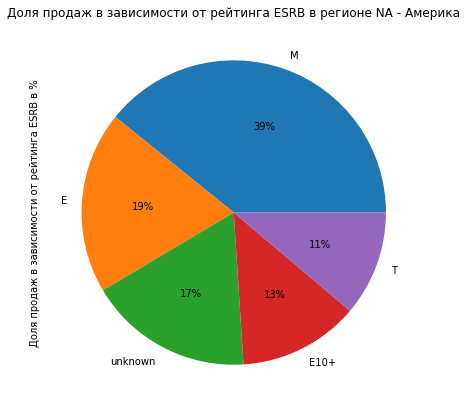

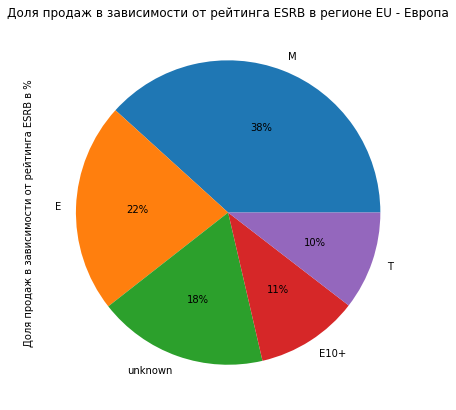

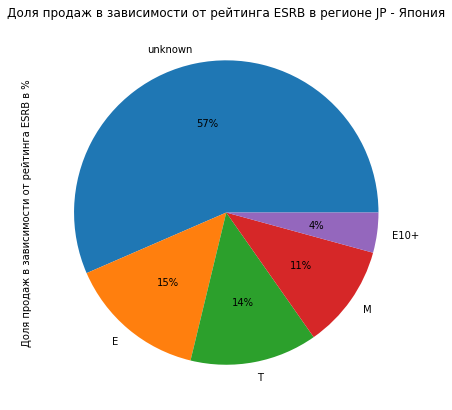

In [42]:
regions = ['na_sales', 'eu_sales', 'jp_sales']

for region in regions:
    if region == 'na_sales':
        name = 'NA - Америка'
    elif region == 'eu_sales':
        name = 'EU - Европа'
    else:
        name = 'JP - Япония'
    (actual_data.pivot_table(index='rating', values=region, aggfunc='sum')
     .sort_values(region, ascending=False)
     .plot(kind='pie', y=region, autopct='%1.0f%%', figsize=(7, 7), legend=False, title = region)
     .set(ylabel='Доля продаж в зависимости от рейтинга ESRB в %')
    )
    plt.title(f'Доля продаж в зависимости от рейтинга ESRB в регионе {name}')
    plt.show()

В регионах NA и EU большая часть продаж приходится на рейтинг "M" (для взрослых), на втором месте с рейтингом для всех "Е", на рынке JP первое место занимают игры с неуказанным рейтингом "unknown", затем игры для всех "Е".

Выводы:

Портрет пользователя в регионах NA и EU почти совпадает. Лидирует платформа PS4, PS3, X360, жанры Action, Sports игры с рейтингом M- для взрослых.
Портрет пользователя из региона JP отличается: пользователь предпочитает консоль 3DS, PS3 жанр Role-Playing, Action игры с неуказанным рейтингом unknown (в Японии есть своя собственная рейтинговая система).

 ### Проверьте гипотезы

1.Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза - cредние рейтинги платформ Xbox One и PC равны.

Альтернативная гипотеза - средние рейтинги платформ XOne и PC не равны.

Нужно будет провести двухстороннюю проверку alternative='two-sided'.
Для подтверждения или опровержения необходимо установить уровень значимости, в рамках данного исследования устанавим 5% или 0,05.

In [43]:
xone = actual_data.query('platform == "XOne" and user_score > -1')
pc = actual_data.query("platform == 'PC' and user_score > -1")

In [44]:
alpha = 0.05

results = st.ttest_ind(
    xone['user_score'], 
    pc['user_score'],
    equal_var=False,
    alternative='two-sided') 

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу, с большой долей вероятности средние пользовательские рейтинги платформ XOne и PC не имеют статистически значимых отличий, при установленном уровне значимости в 5 %.

2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports равны.

Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports не равны.

Нужно будет провести двухстороннюю проверку alternative='two-sided'.
Для подтверждения или опровержения необходимо установить уровень значимости, в рамках данного исследования устанавим 5% или 0,05.

In [45]:
action = actual_data.query('genre == "Action" and user_score > -1')
sports = actual_data.query("genre == 'Sports' and user_score > -1")

In [46]:
alpha = 0.05

results = st.ttest_ind(
    action['user_score'], 
    sports['user_score'],
    equal_var=False,
    alternative='two-sided') 

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

5.989458066467418e-20
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута и исходя от противного, есть основания утверждать, что рейтинги жанров Action и Sports не равны при установленном уровне значимости в 5 %.

 ### Выводы

В рамках данного проекта данные были предобработаны: были изменены названия столбцов; были выявлены пропущенные значения (причиной которых мог быть человеческий фактор или отсутствие данных об оценке в источнике для некоторых данных);в столбцах name и rating пропуски обозначены как unknown, так как данные других столбцов этих строк могут пригодиться для анализа, в столбце year_of_release и genre принято решение удалить строки с пропусками. В столбце critic_score, user_score пропуски и tbd обозначены как -1; дубликаты не обнаружены, неявные дубликаты удалены; столбец year_of_release приведен к int типу, user_score к float в соответствии с данными содержащимися в них, были подсчитаны суммарные продажи во всех регионах (в total_sales).

Исследовательский анализ данных показал, что в датафрейме представлены игры с 1980 по 2016 год. С 90-х по 2009 год наблюдался рост количества релизов игр, с 2009 года прослеживается спад. С 2012 года объем выпуска игр стабилизировался и год от года данные отличаются незначительно (500-600). Для исследования лучше выбрать последние 5 лет, так как этот период должен отражать новейшие тренды в индустрии. Из графиков видно, что от срока появления платформы до их исчезновения как правило проходит около 10 лет, следовательно для нас интересны платформы, созданные в диапазоне 5 лет, у которых должен наблюдаться рост в продажах. За определенный нами актуальный период в 5 лет продажи падают на всех платформах. Диаграммы распределения явно показывают отсутствие линейной связи между оценкой пользователей и продажами и умеренную связь с оценками критиков и продажами для популярных платформ (что подтверждается коэффициентами корреляции). Расчитанная корреляция указывает что между оценкой пользователей и продажами по всей совокупности данных слабая связь (приближается к 0,004). Общая корреляция между оценками критиков и продажами: 0.3 (умеренная связь). За последние годы наиболее востребованными жанрами игр являются Action, Shooter, Role-Playing. У жанров Shooter, Sports и Platform большее медианное значение прибыли.

Портрет пользователя в регионах NA и EU почти совпадает. Лидирует платформа PS4, PS3, X360, жанры Action, Shooter, Sports, игры с рейтингом M - для взрослых.
Портрет пользователя из региона JP отличается: пользователь предпочитает консоль 3DS, PS3, жанр Role-Playing, Action, игры с неуказанным рейтингом unknown (в Японии есть своя собственная рейтинговая система).

Проверка гипотез показала, что есть основания утверждать, что рейтинги платформ XOne и PC равны, при установленном уровне значимости в 5 %. Рейтинги жанров Action и Sports не равны, а значит разные, при установленном уровне значимости в 5 %.

По результатам проведенного исследования можно рекомендовать интернет-магазину "Стримчик" продавать потенциально популярные игры: на платформах PS4 и Xone, в жанрах Action, Shooter и Sports с рейтингом "M" (для взрослых).